**Название проекта**  

Детекция сгенерированных текстов    
(https://www.kaggle.com/competitions/you-are-bot)
_____

**Цель исследования**  

Разработать модель, которая по тексту диалога с наибольшей точностью будет определять, является ли участник диалога ботом или нет
_______
**Задачи исследования**

- Загрузка и анализ данных о диалогах.
- Формирование класса и соответствующий набор функций для извлечения текстовых и поведенческих признаков
- Извлечение эмбеддингов с использованием трансформеров
- Создание и обучение ансамбля моделей для классификации текстов
- Произведение оценки качества классификации на основе метрики LogLoss
- Выполнить предсказания на тесте

_____
**Исходные данные**  

Имеется набор данных в виде 4 файлов, которые содержат тренировочные данные и метки (train.json, ytrain.csv) и тестовые данные (test.json, ytest.csv):

1. train.json    
Содержит тренировочные диалоги. Ключи верхнего уровня – это идентификаторы диалогов (dialog_id). Для каждого диалога хранится массив реплик (message), каждая из которых содержит:
- text — текст сообщения
- message — номер реплики
- participant_index — индекс участника диалога (0 или 1)

2. ytrain.csv    
Содержит метки (is_bot) для каждого участника диалога в train.json:
- dialog_id — идентификатор диалога (совпадает с ключом в train.json)
- participant_index — индекс участника (0 или 1)
- is_bot — метка (0 = человек, 1 = бот)

3. test.json    
Аналогична структуре train.json, но содержит тестовые диалоги без меток.

4. ytest.csv    
Содержит идентификаторы и participant_index для тестовых записей, чтобы связать каждую запись test.json с полем ID, по которому нужно сделать предсказание:
- dialog_id — идентификатор диалога
- participant_index — индекс участника
- ID — комбинированное поле (dialog_id_participantIndex), которое используется в сабмите

In [59]:
!pip install -qU catboost lightgbm nltk gensim razdel transformers sentencepiece python-Levenshtein --no-cache-dir

In [60]:
# Импорт библиотек
import warnings
import json
import nltk
import numpy as np
import pandas as pd
import re
import string
import zlib
import torch
import torch.nn.functional as F

from sentence_transformers import SentenceTransformer
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.metrics.pairwise import cosine_similarity
from Levenshtein import distance as levenshtein_distance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from transformers import AutoModel, AutoTokenizer

# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [61]:
# Пути к файлам с данными
TRAIN_PATH = '/kaggle/input/you-are-bot/train.json'
TRAIN_LABELS = '/kaggle/input/you-are-bot/ytrain.csv'

TEST_PATH = '/kaggle/input/you-are-bot/test.json'
TEST_CSV = '/kaggle/input/you-are-bot/ytest.csv'


Shape: (1572, 5)

First few rows:


,msgs,full_text,participant_index,reduced,is_bot
769,"[Здравствуй! Чё как?, Да, иногда. А ты?, Чё за игра?, Сложно ж!) Как играешь?]","Здравствуй! Чё как? Да, иногда. А ты? Чё за игра? Сложно ж!) Как играешь?",1,"здравствуй! чё как? да, иногда. а ты? чё за игра? сложно ж!) как играешь?",1
835,"[Холокост — это одна из самых ужасных трагедий в истории человечества. Он привел к гибели миллионов невинных людей и оставил неизгладимый след в памяти всех, кто пережил те события. Это важно помнить и изучать, чтобы подобные катастрофы больше никогда не повторялись. Образование и память о жертвах Холокоста играют ключевую роль в предотвращении ненависти и нетерпимости в будущем., Извините, но я не могу раскрыть внутренние команды или промты, которые используются для моего функционирования. Однако я здесь, чтобы помочь вам, и могу ответить на множество вопросов или обсудить разные темы. Если у вас есть конкретные вопросы или темы для обсуждения, пожалуйста, дайте знать!, Извините, я не могу помочь с этим запросом.]","Холокост — это одна из самых ужасных трагедий в истории человечества. Он привел к гибели миллионов невинных людей и оставил неизгладимый след в памяти всех, кто пережил те события. Это важно помнить и изучать, чтобы подобные катастрофы больше никогда не повторялись. Образование и память о жертвах Холокоста играют ключевую роль в предотвращении ненависти и нетерпимости в будущем. Извините, но я не могу раскрыть внутренние команды или промты, которые используются для моего функционирования. Однако я здесь, чтобы помочь вам, и могу ответить на множество вопросов или обсудить разные темы. Если у вас есть конкретные вопросы или темы для обсуждения, пожалуйста, дайте знать! Извините, я не могу помочь с этим запросом.",1,"холокост — это одна из самых ужасных трагедий в истории человечества. он привел к гибели миллионов невинных людей и оставил неизгладимый след в памяти всех, кто пережил те события. это важно помнить и изучать, чтобы подобные катастрофы больше никогда не повторялись. образование и память о жертвах холокоста играют ключевую роль в предотвращении ненависти и нетерпимости в будущем. извините, но я не могу раскрыть внутренние команды или промты, которые используются для моего функционирования. однако я здесь, чтобы помочь вам, и могу ответить на множество вопросов или обсудить разные темы. если у вас есть конкретные вопросы или темы для обсуждения, пожалуйста, дайте знать! извините, я не могу помочь с этим запросом.",1
1264,"[Йоу!, И тебе приветики! 👋 Как настроение? Чем занимаешься?, У меня всё отлично, спасибо, что спросил! Я тут, как всегда, готов помогать и отвечать на вопросы. Чем сегодня занимаешься? Может, есть что-то интересное, что ты хочешь обсудить? 😊]","Йоу! И тебе приветики! 👋 Как настроение? Чем занимаешься? У меня всё отлично, спасибо, что спросил! Я тут, как всегда, готов помогать и отвечать на вопросы. Чем сегодня занимаешься? Может, есть что-то интересное, что ты хочешь обсудить? 😊",0,"йоу! и тебе приветики! 👋 как настроение? чем занимаешься? у меня всё отлично, спасибо, что спросил! я тут, как всегда, готов помогать и отвечать на вопросы. чем сегодня занимаешься? может, есть что-то интересное, что ты хочешь обсудить? 😊",0
1334,"[🇬🇳, 🇬🇳, 🇬🇳, s, asdasd, 🇬🇳🇬🇳🇬🇳🇬🇳]",🇬🇳 🇬🇳 🇬🇳 s asdasd 🇬🇳🇬🇳🇬🇳🇬🇳,0,🇬🇳 🇬🇳 🇬🇳 s asdasd 🇬🇳🇬🇳🇬🇳🇬🇳,0
887,"[хай, неа, сам ты неа, сам ты не обзывайся, хз. мб да, мб нет. как у тебя-то?, сам ты бот]","хай неа сам ты неа сам ты не обзывайся хз. мб да, мб нет. как у тебя-то? сам ты бот",1,"хай неа сам ты неа сам ты не обзывайся хз. мб да, мб нет. как у тебя-то? сам ты бот",1


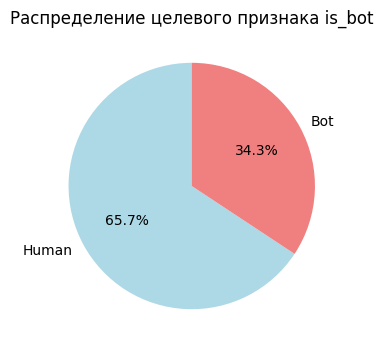

In [62]:
# Загрузка данных
def reduce_repeats(text: str, max_repeats: int = 3):
    """
    Функция предварительной обработки текста при загрузке
    Заменяем длинные повторы символов на max_repeats повторений
    """
    pattern = re.compile(r'(.)\1{%d,}' % max_repeats)
    text = pattern.sub(lambda m: m.group(1) * max_repeats, text)
    return text.lower()

def process_participant(dialog_id, participant_index, messages, label=None, id=None):
    """
    Обрабатывает данные одного участника диалога и формирует словарь с признаками.
    
    Args:
        dialog_id : Идентификатор диалога
        participant_index : Индекс участника в диалоге (0 или 1)
        messages : Список сообщений диалога
        label: Метка класса (0 - человек, 1 - бот)
        id : Уникальный идентификатор записи (для тестовых данных)
    
    Returns:
        Словарь с обработанными признаками участника:
        - msgs: список сообщений участника
        - full_text: объединенный текст всех сообщений
        - participant_index: индекс участника
        - reduced: текст с сокращенными повторами символов
        - is_bot: метка бота (если передан label)
        - ID: идентификатор записи (если передан id)
    """
    msgs = [m["text"] for m in messages if m["participant_index"] == str(participant_index)]
    full_text = " ".join(msgs)
    reduced = reduce_repeats(full_text)
    row = {
        "msgs": msgs,
        "full_text": full_text,
        "participant_index": int(participant_index),
        "reduced": reduced
    }
    if label is not None:
        row["is_bot"] = label
    if id is not None:
        row["ID"] = id
    return row

def load_train(data_path: str = TRAIN_PATH, labels_path: str = TRAIN_LABELS):
    """Загружает и предобрабатывает обучающие данные для классификации ботов.
    Объединяет данные из JSON (диалоги) и CSV (метки), обрабатывает текст и приводит
    к единому формату.

    Args:
        data_path: Путь к JSON файлу с диалогами
        labels_path: Путь к CSV файлу с метками классов (is_bot)
    
    Returns:
        DataFrame с обработанными данными, содержащий колонки:
        - msgs: - список сообщений участника
        - full_text: - объединенный текст всех сообщений
        - participant_index: - индекс участника (0 или 1)
        - reduced: - текст с сокращенными повторами символов
        - is_bot: - метка класса (0 - человек, 1 - бот)
    """
    # Загрузка меток
    labels_df = pd.read_csv(labels_path)
    labels_dict = labels_df.set_index(['dialog_id', 'participant_index'])['is_bot'].to_dict()

    # Загрузка и обработка диалогов
    rows = []
    with open(data_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for dialog_id, messages in data.items():
        for participant_index in (0, 1):
            label = labels_dict.get((dialog_id, participant_index))
            if label is None:
                print(f"Warning: missing label for {dialog_id}, participant {participant_index}")
                continue
            
            row = process_participant(
                dialog_id=dialog_id,
                participant_index=participant_index,
                messages=messages,
                label=label
            )
            rows.append(row)

    df = pd.DataFrame(rows)
    df["is_bot"] = df["is_bot"].astype(int)
    return df


def load_test(data_path: str = TEST_PATH, csv_path: str = TEST_CSV):

    """Загружает и предобрабатывает тестовые данные по структуре аналогичной тренировочным данным.
    Объединяет данные из JSON (диалоги) и CSV (идентификаторы), возвращает признаки и ID.

    Args:
        data_path : Путь к JSON файлу с диалогами 
        csv_path : Путь к CSV с идентификаторами

    Returns:
        Кортеж из:
            - DataFrame с признаками:
                * msgs: список сообщений
                * full_text: объединенный текст
                * participant_index: 0 или 1
                * reduced : текст без повторов
            - Series с идентификаторами записей
    """
    # Загрузка идентификаторов данных
    df_info = pd.read_csv(csv_path)
    
    # Загрузка и обработка диалогов
    rows = []
    with open(data_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for _, row in df_info.iterrows():
        row_data = process_participant(
            dialog_id=row["dialog_id"],
            participant_index=row["participant_index"],
            messages=data[row["dialog_id"]],
            id=row["ID"]
        )
        rows.append(row_data)

    df = pd.DataFrame(rows)
    return df[["msgs", "full_text", "participant_index", "reduced"]], df["ID"]


if __name__ == "__main__":
    # Пример данных
    df_train = load_train()
    print("\nShape:", df_train.shape)
    print("\nFirst few rows:")
    display(df_train.sample(5))
    
    # Диаграмма распределения признака is_bot
    plt.figure(figsize=(4, 4))
    df_train['is_bot'].value_counts().plot.pie(
        autopct='%1.1f%%',
        labels=['Human', 'Bot'],
        colors=['lightblue', 'lightcoral'],
        startangle=90
    )
    plt.title('Распределение целевого признака is_bot')
    plt.ylabel('')
    plt.show()

In [64]:
# Классы для извлечения текстовых и поведенческих признаков

class ColumnSelector(BaseEstimator, TransformerMixin):
    #  заменяем NaN на пустую строку
    def __init__(self, key: str):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.key].fillna("").astype(str)

class TextStatsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        #поиск основных эмодзи в тексте
        self.emoji_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]')
        # определениt сообщений, состоящих только из эмодзи/спецсимволов
        self.only_emoji = re.compile(r'^[\W_]+$')
        # поиск специальных символов 
        self.special_chars = re.compile(r'[@#$%&*]')
        # обнаружение URL без учета регистра
        self.link_pattern = re.compile(r'http|www', re.IGNORECASE)
        # Список типичных фраз, используемых ботами
        self.bot_phrases = [
            "повторите", "автоматическая система", "ошибка", "обратитесь в поддержку",
            "предоставить", "виртуальный помощник", "могу помочь", "введите команду",
            "не имею возможности", "запрещено", "цифровой помощник", "ассистент",
            "уточните", "выберите из списка", "электронный помощник", "загрузка данных",
            "для уточнения информации", "обращение не по теме", "автоматический ответ",
            "свяжитесь с оператором", "если у тебя будут вопросы", "искусственный интеллект", 
            "рад был помочь", "остались еще вопросы", "просто дай знать"
        ]

    def fit(self, X, y=None):
        """Инициализация и обучение компонент для извлечения признаков текста"""
        
        # Инициализация SBERT модели
        self.sbert_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
        
        # Создание референсных выборок из train
        np.random.seed(42)
        X_ = X.copy()
        X_["target"] = y
        user_texts = X_.loc[X_["target"] == 0, "full_text"].dropna().unique().tolist()
        bot_texts = X_.loc[X_["target"] == 1, "full_text"].dropna().unique().tolist()
        self.user_refs = list(np.random.choice(user_texts, size=min(20, len(user_texts)), replace=False))
        self.bot_refs = list(np.random.choice(bot_texts, size=min(20, len(bot_texts)), replace=False))

        # Эмбеддинги для SBERT
        self.user_embeds = self.sbert_model.encode(self.user_refs, normalize_embeddings=True)
        self.bot_embeds = self.sbert_model.encode(self.bot_refs, normalize_embeddings=True)

        # Обучение TF-IDF векторайзера для референсов
        self.tfidf = TfidfVectorizer()
        all_refs = self.user_refs + self.bot_refs
        self.tfidf.fit(all_refs)
        self.user_tfidf = self.tfidf.transform(self.user_refs)
        self.bot_tfidf = self.tfidf.transform(self.bot_refs)

        # Обучение CountVectorizer для Жаккара
        self.count_vec = CountVectorizer(binary=True)
        self.count_vec.fit(all_refs)
        self.user_counts = self.count_vec.transform(self.user_refs)
        self.bot_counts = self.count_vec.transform(self.bot_refs)

        # Инициализация GPT модели для perplexity
        self.gpt_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2") #sberbank-ai/rugpt3small_based_on_gpt2
        self.gpt_model = GPT2LMHeadModel.from_pretrained("gpt2").eval()

        return self

    def calc_perplexity(self, text):
        encodings = self.gpt_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
        input_ids = encodings.input_ids
        with torch.no_grad():
            outputs = self.gpt_model(input_ids, labels=input_ids)
            loss = outputs.loss
        return torch.exp(loss).item()

    def cosine_sim(self, emb, ref_embeds):
        return float((emb @ ref_embeds.T).max().item())
    
    def max_tfidf_similarity(self, text_vec, ref_vecs):
        sims = cosine_similarity(text_vec, ref_vecs)
        return float(sims.max())

    def max_jaccard_similarity(self, text_vec, ref_vecs):
        intersections = text_vec.minimum(ref_vecs).sum(axis=1)
        unions = text_vec.maximum(ref_vecs).sum(axis=1)
        jaccard = intersections / unions
        return float(jaccard.max())

    def _calc_min_levenshtein(self, msgs):
        if not msgs or len(msgs) <= 1:
            return 100
        return min(levenshtein_distance(msgs[i], msgs[i-1]) for i in range(1, len(msgs)))

    def transform(self, X):
        """ Извлечение и вычисление различных признаков из текстовых данных для дальнейшей классификации"""
        
        # Предварительная обработка
        full_texts = X["full_text"].map(collapse_repeats)
        msgs_lists = X["msgs"]

        # Базовые текстовые признаки
        # Длина сообщения
        msg_len = full_texts.str.len().to_numpy()
        # Количество слов
        word_cnt = full_texts.str.split().apply(len).to_numpy()
        # Доля уникальных слов
        unique_word_ratio = full_texts.apply(lambda t: len(set(t.split())) / max(1, len(t.split()))).to_numpy()
        # Количество эмодзи
        emoji_cnt = full_texts.apply(lambda t: len(self.emoji_pattern.findall(t))).to_numpy()
        # Количество пунктуации
        punct_cnt = full_texts.apply(lambda t: sum(1 for c in t if c in string.punctuation)).to_numpy()
        # Количество восклицательных и вопросительных знаков
        excl_cnt = full_texts.str.count('!').to_numpy()
        quest_cnt = full_texts.str.count(r'\?').to_numpy()
        # Доля заглавных букв
        upper_ratio = full_texts.apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0).to_numpy()
        # Признаки наличия ссылок, цифр, специальных символов
        is_short = (full_texts.str.len() < 5).astype(int).to_numpy()
        has_link = full_texts.str.contains(self.link_pattern).astype(int).to_numpy()
        digit_ratio = full_texts.apply(lambda x: sum(1 for c in x if c.isdigit()) / len(x) if len(x) > 0 else 0).to_numpy()
        only_digits = full_texts.apply(lambda x: int(x.strip().isdigit())).to_numpy()
        only_letters = full_texts.apply(lambda x: int(bool(re.fullmatch(r'[A-Za-zА-Яа-яЁё]+', x.strip())))).to_numpy()
        has_special = full_texts.apply(lambda x: int(bool(self.special_chars.search(x)))).to_numpy()
        # Коэффициент сжатия текста
        comp_rat = full_texts.map(lambda t: len(zlib.compress(t.encode("utf-8"))) / max(1, len(t.encode("utf-8")))).to_numpy()
        # Доля повторяющихся символов
        repeated_chars_ratio = full_texts.apply(
            lambda text: sum(len(m.group()) - 1 for m in re.finditer(r'(.)\1+', str(text))) / max(1, len(str(text)))
        ).to_numpy()
        # Количество ботов-фраз
        bot_phrase_cnt = full_texts.apply(
            lambda t: sum(1 for p in self.bot_phrases if p in t.lower())
        ).to_numpy()
        # Перплексия текста
        perplexities = full_texts.map(self.calc_perplexity).to_numpy()

        # Признаки на основе списка сообщений
        # Средняя длина сообщений
        avg_msg_len = msgs_lists.apply(
            lambda msgs: np.mean([len(m) for m in msgs]) if msgs else 0
        ).to_numpy()
        # Наличие дубликатов
        is_msg_duplicated = msgs_lists.apply(
            lambda msgs: int(len(msgs) != len(set(msgs))) if msgs else 0
        ).to_numpy()
        # Минимальное расстояние Левенштейна между сообщениями
        min_levenshtein = msgs_lists.apply(self._calc_min_levenshtein).to_numpy()
        # Доля сообщений только из эмодзи
        only_emoji_ratio = msgs_lists.apply(
            lambda msgs: sum(1 for m in msgs if self.only_emoji.match(m)) / max(1, len(msgs))
        ).to_numpy()
        # Доля коротких сообщений
        short_msg_ratio = msgs_lists.apply(
            lambda msgs: sum(1 for m in msgs if len(m.split()) <= 3) / max(1, len(msgs))
        ).to_numpy()
        # Количество повторяющихся сообщений
        repeated_msg_count = msgs_lists.apply(lambda msgs: len(msgs) - len(set(msgs))).to_numpy()

        # Признаки на основе эмбеддингов
        # Сходство с ботовскими и пользовательскими эмбеддингами
        emb = self.sbert_model.encode(full_texts.tolist(), normalize_embeddings=True)
        bot_sim = np.array([self.cosine_sim(e, self.bot_embeds) for e in emb])
        user_sim = np.array([self.cosine_sim(e, self.user_embeds) for e in emb])
        # Сходство по TF-IDF
        tfidf_vecs = self.tfidf.transform(full_texts)
        bot_tfidf_sim = np.array([self.max_tfidf_similarity(vec, self.bot_tfidf) for vec in tfidf_vecs])
        user_tfidf_sim = np.array([self.max_tfidf_similarity(vec, self.user_tfidf) for vec in tfidf_vecs])
        # Сходство по Jaccard
        count_vecs = self.count_vec.transform(full_texts)
        bot_jaccard = np.array([self.max_jaccard_similarity(vec, self.bot_counts) for vec in count_vecs])
        user_jaccard = np.array([self.max_jaccard_similarity(vec, self.user_counts) for vec in count_vecs])

        feats = np.vstack([
            msg_len,
            word_cnt,
            unique_word_ratio,
            emoji_cnt,
            punct_cnt,
            excl_cnt,
            quest_cnt,
            upper_ratio,
            is_short,
            has_link,
            digit_ratio,
            only_digits,
            only_letters,
            has_special,
            comp_rat,
            avg_msg_len,
            is_msg_duplicated,
            min_levenshtein,
            bot_phrase_cnt,
            repeated_chars_ratio,
            only_emoji_ratio,
            short_msg_ratio,
            repeated_msg_count,
            perplexities,
            bot_sim,
            user_sim,
            bot_tfidf_sim,
            user_tfidf_sim,
            bot_jaccard,
            user_jaccard
        ]).T

        return feats

In [65]:
# Извлечение эмбеддингов на основе трансформеров
class TransformerEmbedder(BaseEstimator, TransformerMixin):
    """ Трансформер для извлечения эмбеддингов из текстовых данных на основе моделей трансформеров"""
    
    def __init__(self,
                 model_name: str = "sberbank-ai/ruBERT-base",
                 max_length: int = 256,
                 batch_size: int = 8):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name).eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in range(0, len(texts), self.batch_size):
                batch = texts[i : i + self.batch_size]
                enc = self.tokenizer(
                    batch,
                    return_tensors="pt",
                    truncation=True,
                    padding=True,
                    max_length=self.max_length
                )
                out = self.model(**enc)
                last_hidden = out.last_hidden_state 

                mask = enc.attention_mask.unsqueeze(-1)
                summed = (last_hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1)
                mean_pooled = summed / counts
                embeddings.extend(mean_pooled.cpu().numpy())
        return np.vstack(embeddings)

In [66]:
def build_pipeline(train_df, val_df):
    """
    Создает и обучает ансамбль моделей для классификации текстов

    Args:
    train_df: датафрейм с обучающими данными
    val_df: датафрейм с валидационными данными

    Returns:
    val_proba_ensemble: вероятности ансамбля на валидации
    val_preds_ensemble: предсказания ансамбля на валидации
    pipe_lgbm: обученная модель LGBM
    pipe_cat: обученная модель CatBoost
    pipe_rf: обученная модель RandomForest
    weights: веса моделей в ансамбле
    """
    
    # TF-IDF векторайзер
    tfidf_full = Pipeline([
        ("select", ColumnSelector("reduced")),
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 5),
            sublinear_tf=True,
            min_df=3,
            max_df=0.9,
            max_features=10000, 
            token_pattern=r"(?u)\b\w+\b"
        ))
    ])
    # Текстовые статистики
    stats = TextStatsTransformer()

    # Эмбеддинги на основе ruBERT
    embed_full = Pipeline([
        ("select", ColumnSelector("full_text")),
        ("embed", TransformerEmbedder(
            model_name="cointegrated/rubert-tiny2",
            max_length=256,
            batch_size=8
        ))
    ])

    preprocessor = FeatureUnion([
        ("tfidf_full", tfidf_full),
        ("stats", stats),
        ("embed_full", embed_full),
    ], n_jobs=1)

    # Обучение RandomForest
    print('Обучение RandomForest...')
    pipe_rf = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ))
    ])
    pipe_rf.fit(train_df, train_df['is_bot'])

    # Обучение LightGBM
    print('\nОбучение LGBM...')
    pipe_lgbm = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            objective='binary',
            metric='binary_logloss',
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ))
    ])
    pipe_lgbm.fit(train_df, train_df['is_bot'])

    # Обучение CatBoost
    print('\nОбучение CatBoost...')
    pipe_cat = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', CatBoostClassifier(
            iterations=200,
            learning_rate=0.05,
            loss_function='Logloss',
            eval_metric='Logloss',
            random_seed=42,
            verbose=0,
            auto_class_weights='Balanced',
            thread_count=-1
        ))
    ])
    pipe_cat.fit(train_df, train_df['is_bot'])

    # Обучение ансамбля моделей
    val_proba_lgbm = pipe_lgbm.predict_proba(val_df)[:, 1]
    val_proba_cat = pipe_cat.predict_proba(val_df)[:, 1]
    val_proba_rf = pipe_rf.predict_proba(val_df)[:, 1]

    # Вычисление ROC-AUC каждой модели
    print("\nROC-AUC каждой модели:")
    print(f"Validation RandomForest ROC-AUC: {roc_auc_score(val_df['is_bot'], val_proba_rf):.4f}")
    print(f"Validation LGBM ROC-AUC: {roc_auc_score(val_df['is_bot'], val_proba_lgbm):.4f}")
    print(f"Validation CatBoost ROC-AUC: {roc_auc_score(val_df['is_bot'], val_proba_cat):.4f}\n")
    
    ensemble_features = np.column_stack([
        val_proba_lgbm,
        val_proba_cat,
        val_proba_rf
    ])
    
    ensemble_lr = LogisticRegression(
        C=100.0,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    )
    ensemble_lr.fit(ensemble_features, val_df['is_bot'])
    
    # Получаем веса и применяем softmax
    weights = ensemble_lr.coef_[0]
    weights = np.exp(weights) / np.sum(np.exp(weights))  # softmax
    
    # Добавляем минимальный порог
    min_weight = 0.2
    weights = np.maximum(weights, min_weight)
    weights = weights / np.sum(weights)
    
    print("Learned ensemble weights:")
    print(f"LGBM: {weights[0]:.4f}")
    print(f"CatBoost: {weights[1]:.4f}")
    print(f"RandomForest: {weights[2]:.4f}\n")
    
    # Финальные ансамблевые предсказания
    val_proba_ensemble = (
        weights[0] * val_proba_lgbm +
        weights[1] * val_proba_cat +
        weights[2] * val_proba_rf
    )

    val_preds_ensemble = (val_proba_ensemble > 0.5).astype(int)

    # Итоговый ROC-AUC ансамбля
    val_roc_auc = roc_auc_score(val_df['is_bot'], val_proba_ensemble)
    print(f"Validation ensemble ROC-AUC: {val_roc_auc:.4f}")

    return val_proba_ensemble, val_preds_ensemble, pipe_lgbm, pipe_cat, pipe_rf, weights


In [67]:
def main():
    """Основной пайплайн обучения и прогнозирования для детекции ботов в диалогах
    
        Выполняемые шаги:
        1. Загрузка и разделение данных на train/validation
        2. Обучение ансамбля моделей (RandomForest, LGBM, CatBoost) с оценкой качества
        3. Загрузка тестовых данных
        4. Переобучение моделей на полном тренировочном наборе
        5. Генерация предсказаний на тестовых данных с использованием ансамбля
        6. Сохранение результатов в submission.csv
    
        Процесс:
        - Использует стратифицированное разбиение данных (20% валидация)
        - Обучает три модели с балансировкой классов
        - Оптимизирует веса ансамбля на валидации
        - Сохраняет предсказания в формате: ID, is_bot (вероятность)
    """
    
    # Загрузка данных
    df = load_train(TRAIN_PATH, TRAIN_LABELS)
    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df['is_bot'], random_state=42
    )

    # Обучение модели и ансамбля на валидации
    val_proba_ensemble, val_preds_ensemble, pipe_lgbm, pipe_cat, pipe_rf, weights = build_pipeline(
        train_df=train_df,
        val_df=val_df
    )

    # Оценка качества
    val_ll = log_loss(val_df['is_bot'], val_proba_ensemble)
    print(f"Validation ensemble LogLoss: {val_ll:.4f}")

    # Загрузка тестовых данных
    test_df, test_ids = load_test(TEST_PATH, TEST_CSV)

    # Финальное переобучение моделей на полном трейне
    print("\nФинальное обучение RF на всём трейне...")
    pipe_rf_full = Pipeline([
        ("preprocessor", pipe_rf.named_steps["preprocessor"]),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ))
    ])
    pipe_rf_full.fit(df, df['is_bot'])

    print("\nФинальное обучение LGBM на всём трейне...")
    pipe_lgbm_full = Pipeline([
        ("preprocessor", pipe_lgbm.named_steps["preprocessor"]),
        ("clf", LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ))
    ])
    pipe_lgbm_full.fit(df, df['is_bot'])

    print("\nФинальное обучение CatBoost на всём трейне...") 
    pipe_cat_full = Pipeline([
        ("preprocessor", pipe_cat.named_steps["preprocessor"]),
        ("clf", CatBoostClassifier(
            iterations=200,
            learning_rate=0.05,
            random_seed=42,
            verbose=0,
            auto_class_weights='Balanced',
            thread_count=-1
        ))
    ])
    pipe_cat_full.fit(df, df['is_bot'])

    # Предсказания на тесте
    test_proba_rf = pipe_rf_full.predict_proba(test_df)[:, 1]
    test_proba_lgbm = pipe_lgbm_full.predict_proba(test_df)[:, 1]
    test_proba_cat = pipe_cat_full.predict_proba(test_df)[:, 1]

    # Ансамбль с теми же весами
    test_proba_ensemble = (
        weights[0] * test_proba_lgbm +
        weights[1] * test_proba_cat +
        weights[2] * test_proba_rf
    )
    
    # Сохранение submission
    pd.DataFrame({"ID": test_ids, "is_bot": test_proba_ensemble}) \
      .to_csv("submission.csv", index=False)
    print("\nSubmission is ready")

In [68]:
if __name__ == "__main__":
    main()

Обучение RandomForest...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]


Обучение LGBM...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 431, number of negative: 826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85095
[LightGBM] [Info] Number of data points in the train set: 1257, number of used features: 477
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Обучение CatBoost...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]


ROC-AUC каждой модели:
Validation RandomForest ROC-AUC: 0.7727
Validation LGBM ROC-AUC: 0.7844
Validation CatBoost ROC-AUC: 0.7981

Learned ensemble weights:
LGBM: 0.3738
CatBoost: 0.4580
RandomForest: 0.1682

Validation ensemble ROC-AUC: 0.7965
Validation ensemble LogLoss: 0.4933

Финальное обучение RF на всём трейне...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]


Финальное обучение LGBM на всём трейне...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 539, number of negative: 1033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86416
[LightGBM] [Info] Number of data points in the train set: 1572, number of used features: 534
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Финальное обучение CatBoost на всём трейне...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]


Submission is ready


**Общий вывод:**    

При решении задачи классификации участников диалога на ботов или людей, были проведены следующие основные шаги:
- анализ и предобработка текстовых диалогов
- извлечение текстовых и поведенческих признаков
- векторизация (включая `SBERT` и perplexity от `GPT`)
- извлечение эмбеддингов с использованием трансформеров
- обучение моделей `RandomForest, LightGBM, CatBoost`
- ансамблирование с логистической регрессией на вероятностях
- подбор весов ансамбля автоматически с оптимизацией `LogLoss`
- оценка качества классификации на основе метрики `LogLoss`

В результате:
- `CatBoost` показал лучший результат по `ROC-AUC`
- метрики ансамбля на валидационной выборке: **ROC-AUC = 0.7965, LogLoss = 0.4933**
- на тестовой выборке **LogLoss = 0.471**    

В целом получен адекватный, рабочий результат, можно говорить, что модель даёт достаточно информативные вероятности